In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 220ms/step - loss: 0.3997 - root_mean_squared_error: 0.6322 - val_loss: 0.3168 - val_root_mean_squared_error: 0.5629
Epoch 2/50
53/53 [==============================] - 10s 195ms/step - loss: 0.2517 - root_mean_squared_error: 0.5017 - val_loss: 0.1085 - val_root_mean_squared_error: 0.3294
Epoch 3/50
53/53 [==============================] - 10s 190ms/step - loss: 0.0910 - root_mean_squared_error: 0.3016 - val_loss: 0.0947 - val_root_mean_squared_error: 0.3078
Epoch 4/50
53/53 [==============================] - 10s 200ms/step - loss: 0.0854 - root_mean_squared_error: 0.2922 - val_loss: 0.0870 - val_root_mean_squared_error: 0.2949
Epoch 5/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0774 - root_mean_squared_error: 0.2782 - val_loss: 0.0810 - val_root_mean_squared_error: 0.2846
Epoch 6/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0713 - root_mean_squared_error: 0.2670 - val_loss: 0.0755 

Epoch 29/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 30/50
53/53 [==============================] - 10s 194ms/step - loss: 0.0146 - root_mean_squared_error: 0.1208 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 31/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 32/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0122 - root_mean_squared_error: 0.1102 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 33/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0120 - root_mean_squared_error: 0.1098 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 34/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071 - val_loss: 0.0136 - va

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.385821314652761 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

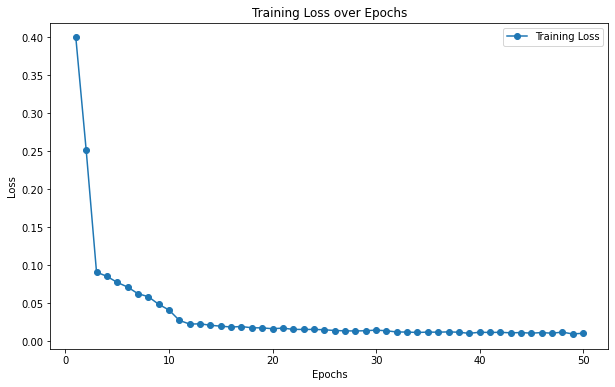

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

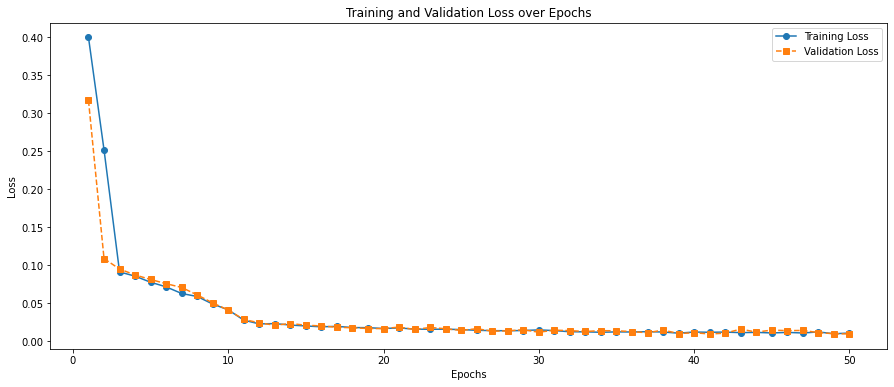

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09775774263410246
MAE : 0.08206400719962485


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.050692e+06,2715890.297
1,1.197083e+06,1053272.694
2,6.651646e+05,368862.123
3,6.573954e+05,979418.298
4,1.624622e+06,2086269.569
5,2.506311e+06,2852731.016
6,3.065665e+06,3452823.613
7,3.481368e+06,3846843.974
8,3.717096e+06,4005222.451
9,3.861861e+06,4129684.505


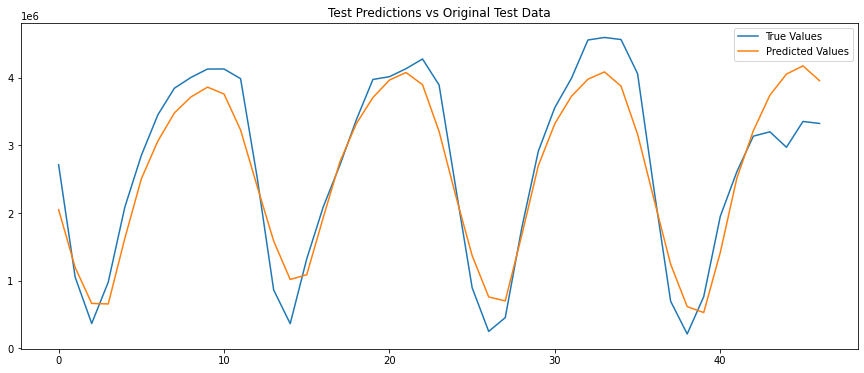

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

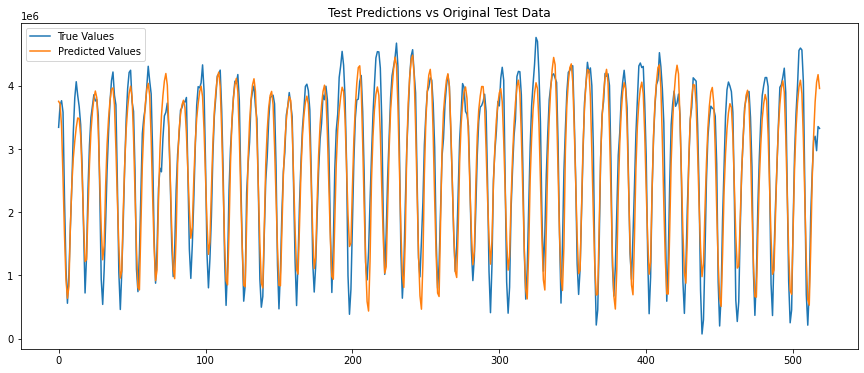

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()